# "Quadrant" graphs for 3-bin a/the trends

- Working with the 3-bin data. Eg, say "a" appears `(100, 90, 70)` times in the three bins.
- Represent that as a 2d vector, where the first dimension is the difference in frequency between bins 1 and 2, the second dimension is the difference between bins 2 and 3. So, here - `(-10, -20)`.
- Relativize the values by the total frequency of the word across all 3 bins.
- Do this for all texts, plot on a 2d plane, where the X-axis is the signed difference between bins 1->2, Y-axis is difference between bins 2->3.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [2]:
import bz2
import os
import ujson
import attr
import math

import pandas as pd
import numpy as np

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from collections import OrderedDict, defaultdict
from pyemd import emd

from sklearn.cluster import AgglomerativeClustering
from scipy import stats

In [3]:
@attr.s
class Dataset:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
    
    def novels(self):
        for path in tqdm_notebook(self.paths()):
            with bz2.open(path) as fh:
                for line in fh:
                    yield ujson.loads(line)

In [4]:
ds = Dataset('../../data/top200-3bins.json/')

In [5]:
novels = list(ds.novels())

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [11]:
np.random.multinomial(100, [1/3, 1/3, 1/3])

array([31, 35, 34])

In [14]:
def plot_quad(token, w=5, h=5, xlim=(-0.2,0.2), ylim=(-0.2,0.2)):

    counts = [np.array(novel['counts'][token]) for novel in novels]
    counts = np.stack([s for s in counts if s.sum() > 100])
    
    rand_counts = np.array([
        np.random.multinomial(c.sum(), [1/3, 1/3, 1/3])
        for c in counts
    ])
    
    q1 = np.stack([s for s in rand_counts if s[1]-s[0] <  0 and s[2]-s[1] >= 0])
    q2 = np.stack([s for s in rand_counts if s[1]-s[0] >= 0 and s[2]-s[1] >= 0])
    q3 = np.stack([s for s in rand_counts if s[1]-s[0] <  0 and s[2]-s[1] <  0])
    q4 = np.stack([s for s in rand_counts if s[1]-s[0] >= 0 and s[2]-s[1] <  0])

    x, y = [], []
    for s in rand_counts:
        x.append((s[1]-s[0])/s.sum())
        y.append((s[2]-s[1])/s.sum())

    plt.figure(figsize=(w,h))
    plt.axhline(0, c='black', linewidth=1)
    plt.axvline(0, c='black', linewidth=1)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.scatter(x, y, s=1, alpha=0.8)
    plt.plot([np.mean(x)], [np.mean(y)], color='black', markersize=7, marker='o')
    
    plt.xlabel('← Falls in first half     Rises in first half →', fontsize=18)
    plt.ylabel('← Falls in second half     Rises in second half →', fontsize=18)
    
    ax = plt.axes([0.15, 0.8, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q1.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q1)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.82, 0.8, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q2.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q2)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.15, 0.14, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q3.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q3)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.82, 0.14, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q4.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q4)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

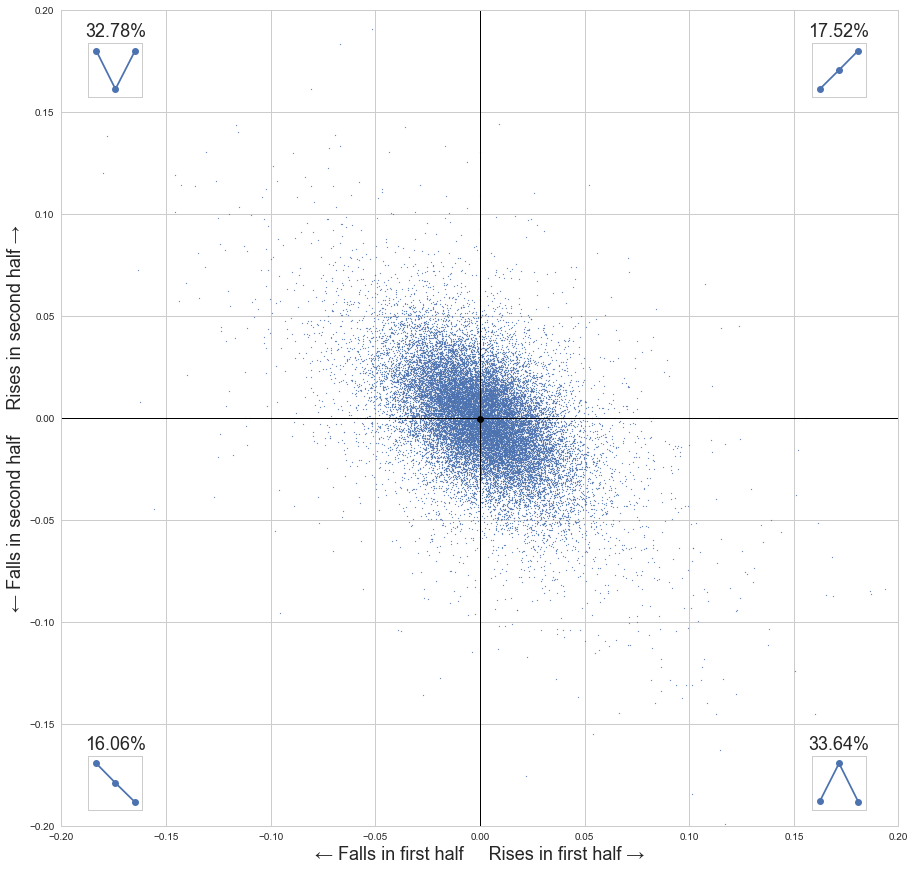

In [15]:
plot_quad('a', 15, 15)

In [16]:
def plot_quad(token, w=5, h=5, xlim=(-0.2,0.2), ylim=(-0.2,0.2)):

    counts = [np.array(novel['counts'][token]) for novel in novels]
    counts = np.stack([s for s in counts if s.sum() > 100])
    
    rand_counts = np.array([
        np.random.multinomial(c.sum(), [1/4, 1/4, 1/4, 1/4])
        for c in counts
    ])
    
    q1 = np.stack([s for s in rand_counts if s[1]-s[0] <  0 and s[3]-s[2] >= 0])
    q2 = np.stack([s for s in rand_counts if s[1]-s[0] >= 0 and s[3]-s[2] >= 0])
    
    q3 = np.stack([s for s in rand_counts if s[1]-s[0] <  0 and s[3]-s[2] <  0])
    q4 = np.stack([s for s in rand_counts if s[1]-s[0] >= 0 and s[3]-s[2] <  0])

    x, y = [], []
    for s in rand_counts:
        x.append((s[1]-s[0])/s.sum())
        y.append((s[3]-s[2])/s.sum())

    plt.figure(figsize=(w,h))
    plt.axhline(0, c='black', linewidth=1)
    plt.axvline(0, c='black', linewidth=1)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.scatter(x, y, s=1, alpha=0.8)
    plt.plot([np.mean(x)], [np.mean(y)], color='black', markersize=7, marker='o')
    
    plt.xlabel('← Falls in first half     Rises in first half →', fontsize=18)
    plt.ylabel('← Falls in second half     Rises in second half →', fontsize=18)
    
    ax = plt.axes([0.15, 0.8, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q1.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q1)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.82, 0.8, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q2.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q2)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.15, 0.14, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q3.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q3)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.82, 0.14, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q4.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q4)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

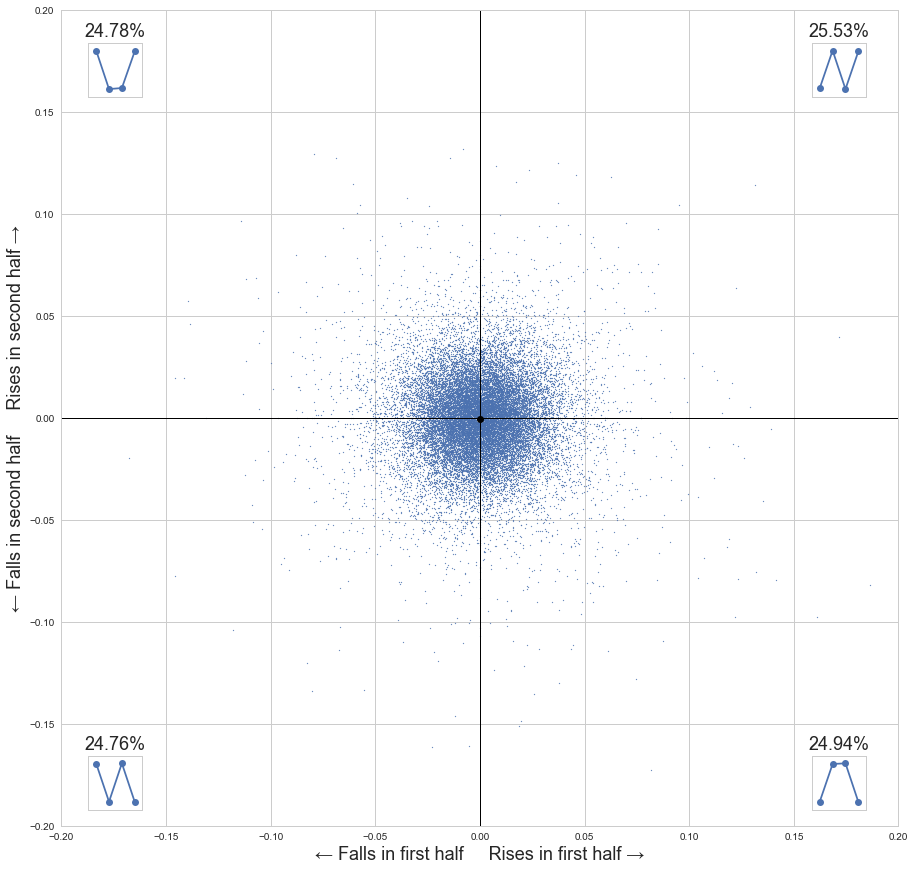

In [17]:
plot_quad('a', 15, 15)